<h1><center>Mentorship Program - Task 1 [BONUS]</center></h1>

Hello and thank you for your time, this is my submission for the bonus exercise of Task 1. At the end, I will be giving multiple random numbers as inputs, including the $[1,5,7,10]$ case.

My intention is to give brief explanations of how I solved the problem and how the code works. If the code looks self-explanatory to you, feel free to skip the explanations.

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

simulator = QasmSimulator()

The approach used is the same as what was proposed in the _context_ section of the task: Create a QRAM to load the data, and then apply Amplitude Amplification to shift the probabilities to the elements that satisfy the condition. The quantum circuit will have the following qubits and bits:
* $n$ address qubits, used for indexing $2^n$ input elements
* $m$ memory qubits for storing the input. We will have as many memory qubits as bits are needed to represent the largest input number in binary
* $m-1$ ancilla qubits, used in the oracle
* One final $|-\rangle$ qubit for phase kickback


I have divided everything in different functions that I will explain now.

## Initial steps and QRAM

Before loading the input, we want to have our address qubits in equal superposition and, while we are at it, initialize our $|-\rangle$ qubit. This is done in the function _preparation_, which applies these gates to the input circuit.

In [2]:
"""
Applies the Hadamard gate to address
qubits (first n qubits).
Initializes the last qubit to |−⟩

#Parameters:
* n: Number of address qubits
* circuit: circuit to which apply the gates
"""
def preparation(n: int, circuit: QuantumCircuit):
    for i in range(n):
        circuit.h(i)
    circuit.x(circuit.num_qubits-1)
    circuit.h(circuit.num_qubits-1)
    circuit.barrier()

Now comes the QRAM implementation. As we know, we need a circuit that does the following:

$$ \frac{1}{\sqrt{2^n}} \sum_x|x\rangle|0\rangle \mapsto \frac{1}{\sqrt{2^n}} \sum_x|x\rangle|input[x]\rangle$$

This is achieved in the next function, _loading_, by doing the following for each input number:
1. Clasically convert the number and its index to binary representation.
2. Apply X gate to the address qubits that correspond to the index bits with value 0
3. Apply X gate controlled on every address qubit to all memory qubits that need to have value 1
4. Reverse step 2

These steps are converted to a single gate later for cleanliness, but we can see now how the circuit for this part looks with input $[1,5,7,10]$:

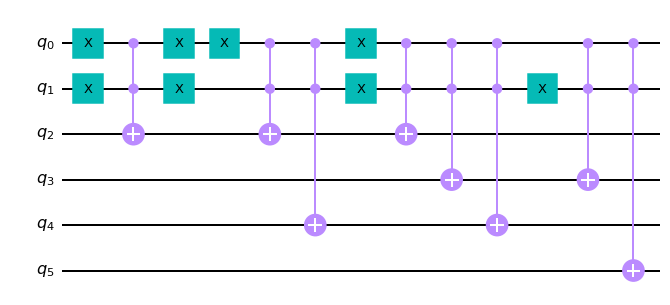

In [3]:
"""
Implements the QRAM for input loading.

# Parameters:
* n: Number of address qubits
* m: Length in bits of the input numbers
* numbers: List of input numbers
* debug: Flag for visualizing the circuit

# Returns:
Gate object with the QRAM implementation.
"""
def loading(n: int, m: int, numbers: list, debug=False):
    circuit = QuantumCircuit(n+m)
    for i in range(len(numbers)): # Loop through input list
        
        # Convert number to binary
        binNum = list(map(int,bin(numbers[i])[2:]))
        binNum = np.pad(binNum, (m-len(binNum),0))[::-1]
        
        # Convert number index to binary
        binAddress = list(map(int,bin(i)[2:]))
        binAddress = np.pad(binAddress, (n-len(binAddress),0))

        for j in range(n): # NOT address qubits with value 0
            if binAddress[j] == 0:
                circuit.x(j)
        for j in range(m): # MCX to memory qubits that should be 1
            if binNum[j] == 1:
                idx = n+j
                circuit.mcx(list(range(n)),idx)
        for j in range(n): # Uncompute previous NOTs
            if binAddress[j] == 0:
                circuit.x(j)
    if not debug:
        circuit = circuit.to_gate()
        circuit.name = " Load"
    return circuit

circuit = loading(2,4,[1,5,7,10],debug=True)
circuit.draw(output='mpl')

## Amplitude Amplification

Now that we have our input loaded in equal superposition, what is left is to amplify the amplitudes of our targets. As we know, we need an Oracle to flip the sign of our targets. These targets can be found by applying 2 CNOT gates controlled in every pair of adjacent memory bits with target an ancilla bit. This is done by the function _oracle_ below (note, the XOR with the $|-\rangle$ qubit is done outside this function):

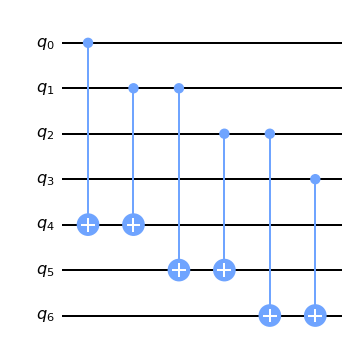

In [4]:
"""
Implements the oracle.

# Parameters:
* m: Length in bits of the input numbers
* ancillas: Number of ancillas qubits needed
* numbers: List of input numbers
* debug: Flag for visualizing the circuit

# Returns:
Gate object with the oracle implementation.
"""
def oracle(m: int, ancillas: int, numbers: list, debug=False):
    circuit = QuantumCircuit(m+ancillas)
    for i in range(ancillas):
        circuit.cx(i, m+i)
        circuit.cx(i+1, m+i)
    if not debug:
        circuit = circuit.to_gate()
        circuit.name = " U$_f$"
    return circuit

circuit = oracle(4, 3, [1,5,7,10], debug=True)
circuit.draw(output='mpl')

Apart from the Oracle, we need the diffuser. In this case, I'm using the diffuser implementation from the [Qiskit Textbook](https://qiskit.org/textbook/ch-algorithms/grover.html#3.1-Qiskit-Implementation-) from the chapter on Grover's Algorithm. They provide a great explanation on how it works.

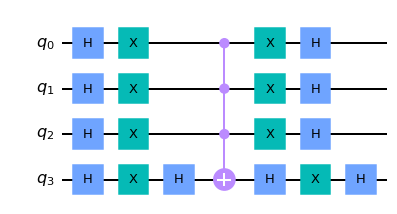

In [5]:
def diffuser(nqubits, debug=False):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    if not debug:
        qc = qc.to_gate()
        qc.name = " U$_s$"
    return qc

circuit = diffuser(4, debug=True)
circuit.draw(output='mpl')

## Putting it all together

We have all the pieces of our puzzle, what is left is to use them correctly. Here are some things to take into consideration:
* We know that, for any $m$, there can only be $2$ possible correct solutions
* When our input is of size 4, we shall add an extra qubit. Otherwise, the amplitudes remain unchanged due to the solutions being half of the input space
* We will need $\left\lfloor \frac{\pi}{4}\sqrt{\frac{2^n}{2}} \right\rfloor$ iterations
* In every iteration, we perform $load \rightarrow oracle \rightarrow phase \ kickback \rightarrow oracle^\dagger \rightarrow load^\dagger \rightarrow diffuser$
* We measure on the address qubits at the very end
* When printing the histograms of measurement results, remember the numbers are inverted.

Correct numbers are: 5, 10 in positions 1, 3
Iterations: 1


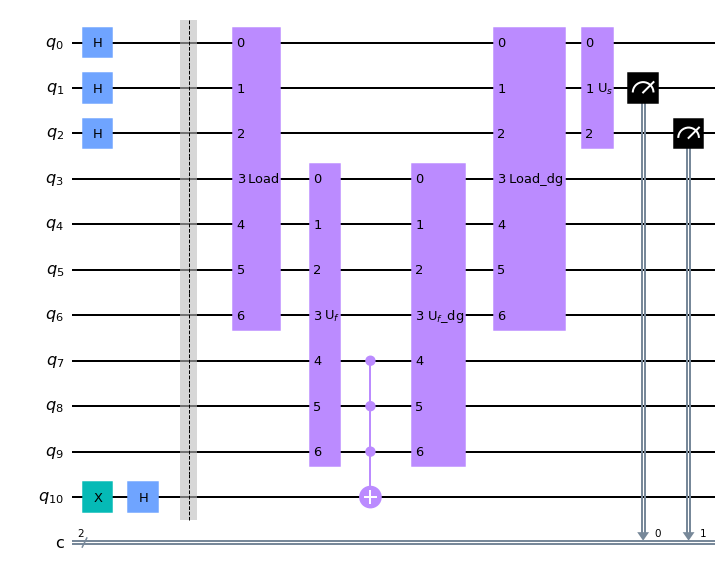

In [6]:
"""
Finds numbers with interleaving binary representation.

# Parameters:
* n: Number of address qubits
* m: Length in bits of the input numbers
* numbers: List of input numbers

# Returns:
Circuit with QRAM + Amplitude Amplification algorithm
"""
def search(n: int, m: int, numbers: list) -> QuantumCircuit:
    
    extra = 0
    if len(numbers) == 4:
        n += 1
        extra += 1
    ancillas = max(2,m-1)
    circuit = QuantumCircuit(n+m+ancillas+1,n-extra)
    iterations = math.floor(math.pi/4 *math.sqrt((2**n)/2))

    preparation(n, circuit)
    load = loading(n,m,numbers)
    amplify = oracle(m, ancillas, numbers)
    print('Iterations:',iterations)
    for i in range(iterations):
        circuit.append(load, list(range(n+m)) )
        circuit.append(amplify, list(range(n,n+m+ancillas)) )
        circuit.mct(list(range(n+m,n+m+ancillas)),n+m+ancillas)
        circuit.append(amplify.inverse(), list(range(n,n+m+ancillas)) )
        circuit.append(load.inverse(), list(range(n+m)) )
        circuit.append(diffuser(n), list(range(n)))
    circuit.measure(list(range(extra,n)), list(range(n-extra)))
    return circuit
    
"""
For demonstration purposes. Given an m, returns
representation in base10 of numbers with m alternating bits. 
"""
def getCorrectNumbers(m: int) -> tuple:
    return sum(2**x for x in range(0,m,2)), sum(2**x for x in range(1,m,2))

n = 2
m = 4
inputList = [1,5,7,10]
a,b = getCorrectNumbers(m)
print(f"Correct numbers are: {a}, {b} in positions {inputList.index(a)}, {inputList.index(b)}")
circuit = search(n, m, inputList)
circuit.draw(output='mpl')

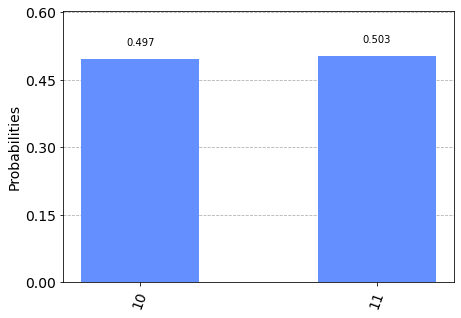

In [7]:
job = execute(circuit, simulator, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

As we can see, the algorithm works for the $[1,5,7,10]$ case (remember to read the bitstrings in the histogram in reverse order). Let's now generate some more examples and see it works:

In [8]:
# Modify these parameters as you please to test the algortihm.

n = 3
m = 6
inputList = [1,5,21,10,2,4,6,42]

a,b = getCorrectNumbers(m)
print(f"Correct numbers are: {a}, {b} in positions {inputList.index(a)}, {inputList.index(b)}")
circuit = search(n, m, inputList)

Correct numbers are: 21, 42 in positions 2, 7
Iterations: 1


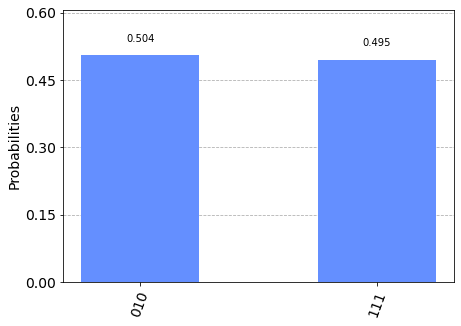

In [9]:
job = execute(circuit, simulator, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

In [10]:
n = 4
m = 7
inputList = [1,5,21,85,2,4,6,13,3,7,8,9,11,12,42,14]

a,b = getCorrectNumbers(m)
print(f"Correct numbers are: {a}, {b} in positions {inputList.index(a)}, {inputList.index(b)}")
circuit = search(n, m, inputList)

Correct numbers are: 85, 42 in positions 3, 14
Iterations: 2


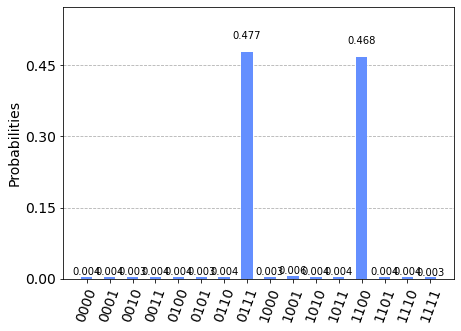

In [11]:
job = execute(circuit, simulator, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

Thanks to QOSF for the challenge and the opportunity!!

# References

https://github.com/qsharp-community/qram/blob/master/docs/primer.pdf

https://qiskit.org/textbook/ch-algorithms/grover.html

https://en.wikipedia.org/wiki/Grover's_algorithm

https://arxiv.org/pdf/1803.01958.pdf

<h1><center>The end</center></h1>